# StyleGAN3: hi-res generative modeling

## [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ml4a/ml4a-guides/blob/ml4a.net/examples/models/stylegan3.ipynb)

This module is based on the [original code](https://github.com/NVlabs/stylegan3) and [paper](https://arxiv.org/abs/2106.12423) by NVIDIA, and comes with several pre-trained models, as well as functions for sampling from the GAN, generating interpolations, and performing operations on the latent space to achieve style-transfer like effects.

## Set up ml4a and enable GPU

If you don't already have ml4a installed, or you are opening this in Colab, first enable GPU (`Runtime` > `Change runtime type`), then run the following cell to install ml4a and its dependencies.

In [ ]:
%tensorflow_version 1.x
!pip3 install --quiet ml4a

## Load stylegan 

You can see what pre-trained models are available with `stylegan3.get_pretrained_models`.

In [1]:
from ml4a import image
from ml4a.models import stylegan3

stylegan3.get_pretrained_models()

dict_keys(['ffhq-t', 'ffhq-r', 'ffhqu-t', 'ffhqu-r', 'metfaces-t', 'metfaces-r', 'afhqv2-t', 'afhqv2-r'])

The variable `network_pkl` refers to the location of the trained pkl file. You can load your own pkl locally from your computer, or get one of the pretrained models listed above.

In [2]:
network_pkl = stylegan3.get_pretrained_model('ffhqu-t')
#network_pkl = 'network-snapshot-001120.pkl'
stylegan3.load_model(network_pkl)

## Generate random samples

`stylegan2.random_sample(n)` will generate `n` random images from the latent space of your trained model. If your model is conditional, you must also supply a label vector.

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


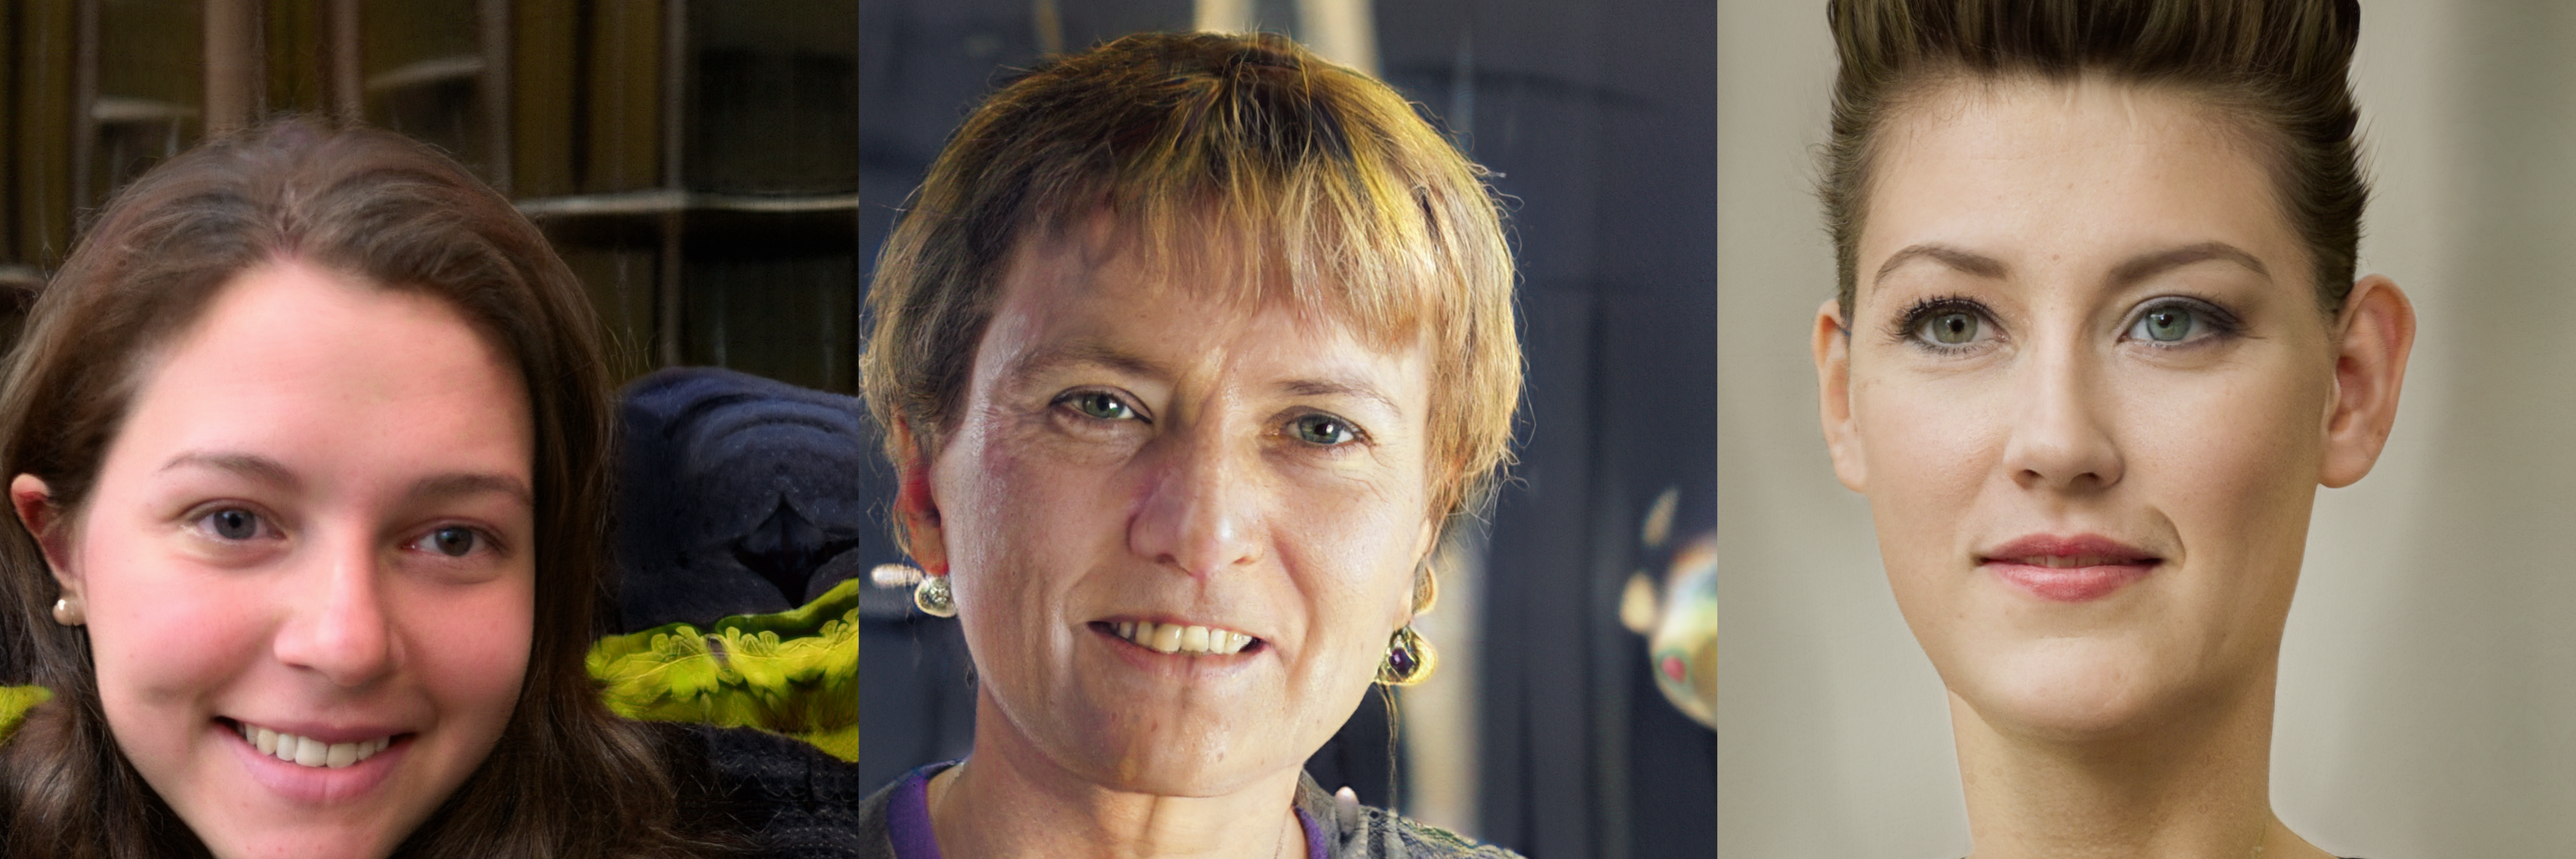

In [3]:
samples, _ = stylegan3.random_sample(3, label=None, truncation=1.0)
image.display(samples)

You can quickly generate a "latent walk" video, a random interpolation through the latent space of your model of `duration_sec` seconds long, with `stylegan2.generate_interpolation_video`.

In [4]:
latent_video = stylegan3.generate_interpolation_video2(
    'latent_interpolation.mp4', 
    labels=None,
    truncation=1, 
    duration_sec=25.0,
    smoothing_sec=5.0
)

Moviepy - Building video latent_interpolation.mp4.
Moviepy - Writing video latent_interpolation.mp4



Moviepy - Done !
Moviepy - video ready latent_interpolation.mp4


Display the generated video inline in the notebook.

In [2]:
image.display_local(latent_video)

In [10]:
import torch
import numpy as np
import moviepy.editor

# latent_video = stylegan3.generate_interpolation_video2(
#     'latent_interpolation.mp4', 
#     labels=None,
#     truncation=1, 
#     duration_sec=25.0,
#     smoothing_sec=5.0
# )

output_path = 'test.mp4'
truncation=1
noise_mode='const' 
duration_sec=5.0
smoothing_sec=1.0
minibatch_size=16
mp4_fps = 30
seed = 90

num_frames = int(np.rint(duration_sec * mp4_fps))    
all_latents = stylegan3.get_gaussian_latents(duration_sec, smoothing_sec, mp4_fps, seed)
all_labels = None

def make_frame(t):
    frame_idx = 0 #int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    the_latents = all_latents[frame_idx]
    labels = None #all_labels[frame_idx].reshape((1, 7))
    translate, rotate = [t/10.0, 0], 0
    if hasattr(stylegan3.G.synthesis, 'input'):
        m = stylegan3.gen_images.make_transform(translate, rotate)
        m = np.linalg.inv(m)
        stylegan3.G.synthesis.input.transform.copy_(torch.from_numpy(m))
    images = stylegan3.G(the_latents, labels, truncation_psi=truncation, noise_mode=noise_mode)
    images = (images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    images = images[0].cpu().numpy()
    return images

clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
clip.write_videofile(output_path, fps=30, codec='libx264', bitrate='16M')


Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


SyntaxError: 'return' outside function (<ipython-input-10-ea6723bf071e>, line 42)